In [1]:
# generate a nn agent for a communication game, there should be a fixed number of meanings and words and the two agents should interact to communicate 
# about these meanings 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

# set random seed for reproducibility
random.seed(42)

torch.manual_seed(42)

In [ ]:
class Agent:
    def __init__(self, n_meanings, n_signals, alpha=0.1, decay=0.0, epsilon=0.05):
        """
        Steels (1995)-style agent with reinforcement learning and lateral inhibition.

        Parameters
        ----------
        n_meanings : int
            Number of possible meanings (concepts).
        n_signals : int
            Number of possible signals (forms).
        alpha : float
            Learning rate (strength of updates, e.g. 0.1).
        decay : float
            Global forgetting rate per interaction (e.g. 0.01).
        epsilon : float
            Exploration probability (chance to pick a random signal).
        """
        self.n_meanings = n_meanings
        self.n_signals = n_signals
        self.alpha = alpha
        self.decay = decay
        self.epsilon = epsilon

        # Initialize lexicon: meaning × signal → weight
        self.lexicon = {
            m: {s: 0.1 for s in range(n_signals)}
            for m in range(n_meanings)
        }

    # === SPEAKER ===
    def getSignal(self, meaning):
        """
        Choose a signal for a given meaning.
        - Mostly picks based on learned weights.
        - Occasionally explores a random signal (epsilon).
        """
        if random.random() < self.epsilon:
            return random.randint(0, self.n_signals - 1)

        weights = self.lexicon[meaning]
        total = sum(weights.values())

        if total == 0:
            return random.randint(0, self.n_signals - 1)

        signals, probs = zip(*[(s, w / total) for s, w in weights.items()])
        return random.choices(signals, probs)[0]

    # === HEARER ===
    def guessMeaning(self, sigma):
        """
        Guess which meaning a signal refers to, based on weights.
        """
        scores = [self.lexicon[m].get(sigma, 0) for m in range(self.n_meanings)]
        total = sum(scores)
        if total == 0:
            return random.randint(0, self.n_meanings - 1)

        probs = [s / total for s in scores]
        return random.choices(range(self.n_meanings), probs)[0]

    # === LEARNING ===
    def update(self, outcome, meaning, sigma, guess):
        """
        Update association strengths after an interaction.

        Implements:
        - Reinforcement for successful mappings.
        - Lateral inhibition to promote one-to-one mappings.
        - Weakening for unsuccessful ones.
        - Optional global decay.
        """
        # Global decay (forgetting)
        if self.decay > 0:
            for m in range(self.n_meanings):
                for s in range(self.n_signals):
                    self.lexicon[m][s] *= (1 - self.decay)

        if outcome:  # success
            # Reinforce the successful meaning-signal mapping
            self.lexicon[meaning][sigma] += self.alpha * (1 - self.lexicon[meaning][sigma])

            # Lateral inhibition: competing signals for same meaning
            for s in self.lexicon[meaning]:
                if s != sigma:
                    self.lexicon[meaning][s] *= (1 - self.alpha)

            # Lateral inhibition: same signal for other meanings
            for m in range(self.n_meanings):
                if m != meaning:
                    self.lexicon[m][sigma] *= (1 - self.alpha)

        else:  # failure
            # Weaken this specific mapping
            self.lexicon[meaning][sigma] *= (1 - self.alpha)

    def __repr__(self):
        return f"<Agent n_meanings={self.n_meanings} n_signals={self.n_signals}>"


In [59]:
def simulate_rounds(n_rounds=100, 
                    n_meanings=3, 
                    n_signals=5, 
                    alpha=0.1, # learning rate
                    decay=0.1, # forgetting rate
                    epsilon=0.05): # exploration rate
    df = pd.DataFrame(columns=["round", "meaning", "signal", "guess", "outcome"])

    A = Agent(n_meanings, 
              n_signals, 
              alpha, 
              decay, 
              epsilon)
    B = Agent(n_meanings, 
              n_signals,
              alpha, 
              decay, 
              epsilon)

    for t in range(1, n_rounds + 1):
        meaning = random.randint(0, n_meanings - 1)
        sigma = A.getSignal(meaning)
        guess = B.guessMeaning(sigma)
        outcome = int(guess == meaning)

        # Update both agents
        A.update(outcome, meaning, sigma, guess)
        B.update(outcome, meaning, sigma, guess)

        print(f"Round {t:2d}: meaning={meaning}, sigma={sigma}, "
              f"guess={guess}, outcome={outcome}")
        df = pd.concat([df, pd.DataFrame({"round": [t], "meaning": [meaning], 
                                          "signal": [sigma], "guess": [guess], 
                                          "outcome": [outcome]})], ignore_index=True)
    return df

In [87]:

num_agents = 5
n_meanings = 5
n_signals = 5
n_rounds = 100

agents = [Agent(n_meanings=n_meanings, n_signals=n_signals) for _ in range(num_agents)]
pairs = [(i, j) for i in range(num_agents) for j in range(i + 1, num_agents)]

# Step 1: create all pair-round slots
interaction_list = []
for pair in pairs:
    i, j = pair
    for r in range(1, n_rounds + 1):
        interaction_list.append((i, j, r))

# Step 2: shuffle to randomize interaction order
random.shuffle(interaction_list)

# Step 3: run interactions
df = pd.DataFrame(columns=["round", "meaning", "signal", 
                           "guess", "outcome", "pair"])

records = []

for i, j, r in interaction_list:
    if r % 2 == 0:
        sender, receiver = agents[i], agents[j]
        pair_label = f"{i}:{j}"
    else:
        sender, receiver = agents[j], agents[i]
        pair_label = f"{i}:{j}"

    meaning = random.randint(0, n_meanings - 1)
    signal = sender.getSignal(meaning)
    guess = receiver.guessMeaning(signal)
    outcome = int(guess == meaning)

    sender.update(outcome, meaning, signal, guess)
    receiver.update(outcome, meaning, signal, guess)



    records.append({
        "round": r,
        "meaning": meaning,
        "signal": signal,
        "guess": guess,
        "outcome": outcome,
        "pair": pair_label
    })

df = pd.DataFrame(records)

print(df.tail())

     round  meaning  signal  guess  outcome pair
995     50        1       4      1        1  0:3
996     29        2       0      2        1  2:4
997     36        4       2      4        1  3:4
998      6        0       1      0        1  0:4
999     49        0       1      0        1  2:4


In [88]:
# number of interactions per pair
interactions_per_pair = df['pair'].value_counts()
interactions_per_pair

pair
0:3    100
1:2    100
0:4    100
3:4    100
0:1    100
1:4    100
2:3    100
1:3    100
0:2    100
2:4    100
Name: count, dtype: int64

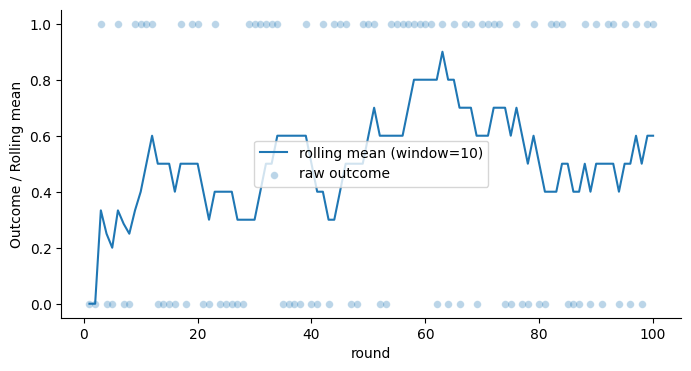

In [89]:
# plot jiust one diad
df_pair = df[df["pair"] == "0:1"]
plt.figure(figsize=(8, 4))
window = 10

df_pair = df_pair.copy()
df_pair['round'] = df_pair['round'].astype(int)
df_pair = df_pair.sort_values('round')
df_pair['outcome'] = pd.to_numeric(df_pair['outcome'])
df_pair['rolling_mean'] = df_pair['outcome'].rolling(window=window, min_periods=1).mean()

sns.lineplot(data=df_pair, x='round', y='rolling_mean', label=f'rolling mean (window={window})')
sns.scatterplot(data=df_pair, x='round', y='outcome', alpha=0.3, s=30, label='raw outcome')
plt.ylabel('Outcome / Rolling mean')
plt.legend()
sns.despine()
plt.show()

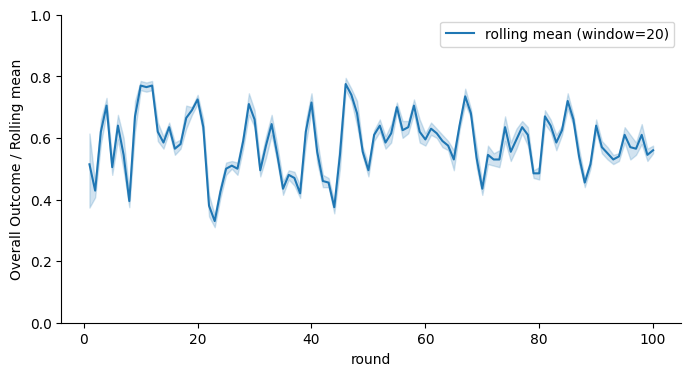

In [93]:
# plot overall performance
plt.figure(figsize=(8, 4))
window = 20
df = df.copy()
df['round'] = df['round'].astype(int)
df = df.sort_values('round')
df['outcome'] = pd.to_numeric(df['outcome'])
df['rolling_mean'] = df['outcome'].rolling(window=window, min_periods=1).mean()
sns.lineplot(data=df, x='round', y='rolling_mean', label=f'rolling mean (window={window})')
plt.ylabel('Overall Outcome / Rolling mean')
plt.legend()
sns.despine()
plt.ylim(0, 1)
plt.show()

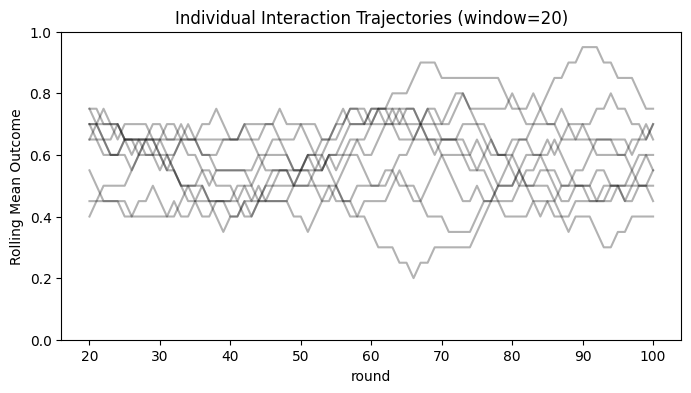

In [94]:
# plot individual trajectories for all pairs
plt.figure(figsize=(8, 4))
window = 20
for pair_id, df_pair in df.groupby("pair"):
    df_pair = df_pair.copy()
    df_pair['round'] = df_pair['round'].astype(int)
    df_pair = df_pair.sort_values('round')
    df_pair['outcome'] = pd.to_numeric(df_pair['outcome'])
    df_pair['rolling_mean'] = df_pair['outcome'].rolling(window=window).mean()

    sns.lineplot(data=df_pair, x='round', y='rolling_mean', 
                 alpha=0.3, color='black')
plt.ylabel('Rolling Mean Outcome')
plt.title(f'Individual Interaction Trajectories (window={window})')
plt.ylim(0, 1)
plt.show()